In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import annotate
import n_1rxi as method
import plot_utils

In [9]:
chunk_size = 20

In [10]:
fname = method.__file__.split('/')[-1][:-3].replace('x', str(chunk_size)) + '-omni'
fname

'n_1r20i-omni'

In [11]:
import rate
rate.setkey(1,'gpt')
rate.model = 'gpt-4o'

In [12]:
source = annotate.get_clean()

In [13]:
source = source.sample(frac=1, random_state=8)

In [14]:
requests = await method.rate(source, chunk_size=chunk_size)

Request 1 of 243
Request 2 of 243
Request 3 of 243
Request 4 of 243
Request 5 of 243
Request 6 of 243
Request 7 of 243
Request 8 of 243
Request 9 of 243
Request 10 of 243
Request 11 of 243
Request 12 of 243
Request 13 of 243
Request 14 of 243
Request 15 of 243
Request 16 of 243
Request 17 of 243
Request 18 of 243
Request 19 of 243
Request 20 of 243
Request 21 of 243
Request 22 of 243
Request 23 of 243
Request 24 of 243
Request 25 of 243
Request 26 of 243
Request 27 of 243
Request 28 of 243
Request 29 of 243
Request 30 of 243
Request 31 of 243
Request 32 of 243
Request 33 of 243
Request 34 of 243
Request 35 of 243
Request 36 of 243
Request 37 of 243
Request 38 of 243
Request 39 of 243
Request 40 of 243
Request 41 of 243
Request 42 of 243
Request 43 of 243
Request 44 of 243
Request 45 of 243
Request 46 of 243
Request 47 of 243
Request 48 of 243
Request 49 of 243
Request 50 of 243
Request 51 of 243
Request 52 of 243
Request 53 of 243
Request 54 of 243
Request 55 of 243
Request 56 of 243
R

In [29]:
import importlib
importlib.reload(method)

<module 'n_1rxi' from '/home/felix/projects/elo-gpt/n_1rxi.py'>

In [30]:
failed = method.process(requests)

Failed parse (chunk 0, request #162). Prompt:
'''We aim to evaluate the creativity of ideas in an Alternative Uses Tests (AUT) based on specific criteria. Please rate our ideas, given below, in terms of their Novelty, which is defined as follows:
Novelty: Rate the novelty of the idea on a scale of 1 to 100, with 1 being not novel at all and 100 being extremely novel. Consider how unique, original, or surprising the idea is, while disregarding its feasibility and value.

Proceed as follows in your evaluation. Write 3 lines for each item in the list below. On the first line, write the item number and briefly describe the idea in your own words. On the second line, consider other unconventional uses of the item, including those listed, and compare the idea to these in terms of its Novelty. Finally, on the third line, provide your numeric rating as a json object of the form {"novelty":x}. Evaluate each idea in the order provided, leaving one empty line between evaluations. Do evaluate each

In [31]:
temp = 0.1
while temp < 0.5:
    await rate.entrypoint(failed, temperature=temp)
    failed = method.process(failed)
    temp += .1

Request 1 of 1


In [32]:
source.to_excel(f'gpt-ratings/{fname}.xlsx')

In [33]:
source = pd.read_excel(f'gpt-ratings/{fname}.xlsx')

In [34]:
corr = {key: stats.spearmanr(source[[key.capitalize(), key]]) for key in annotate.measures}
corr

{'novelty': SignificanceResult(statistic=0.6264377049632254, pvalue=3.610194864690849e-134),
 'feasibility': SignificanceResult(statistic=0.6430590276154202, pvalue=1.5210883002443e-143),
 'value': SignificanceResult(statistic=0.32648807373302074, pvalue=9.58395831704611e-32)}

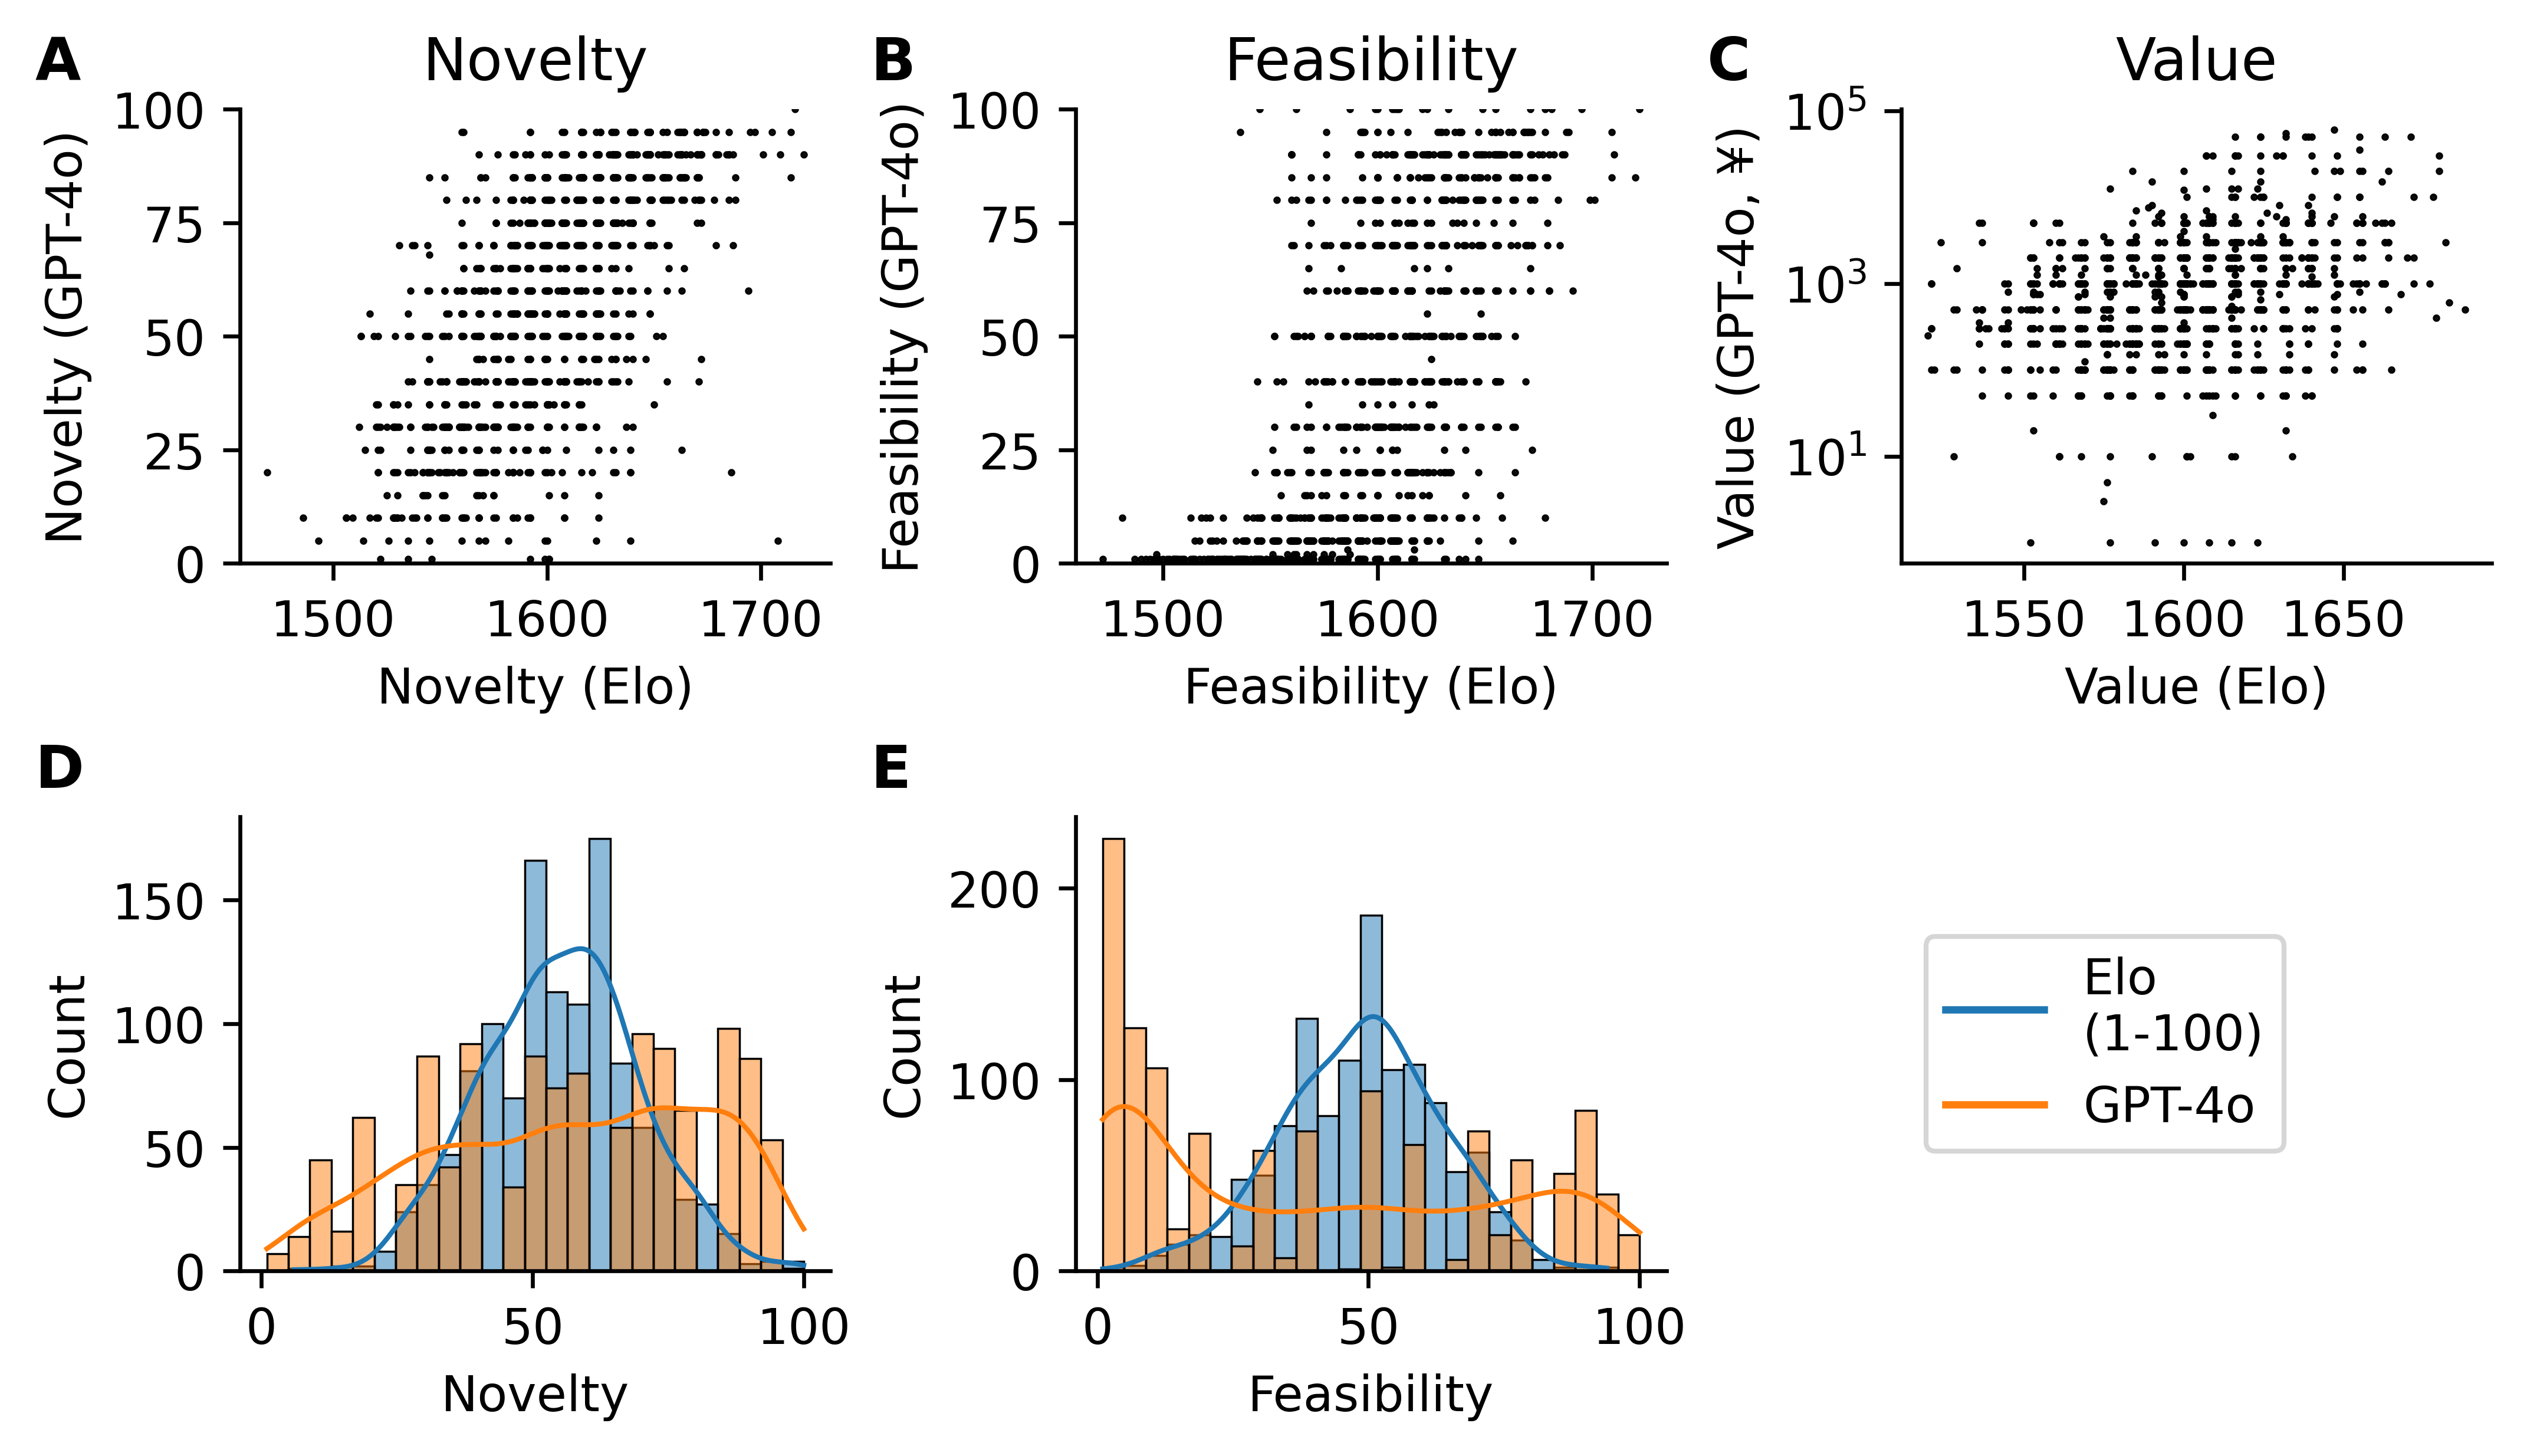

In [35]:
fig, axs = plt.subplots(2, 3, figsize=(7,4), layout='constrained', dpi=600)
for measure, ax in zip(annotate.measures, axs.T):
    Measure = measure.capitalize()
    if measure == 'value':
        mask = (source['value']>0) & (source['value']<100000)
        suffix = ', ¥'
        ax[0].semilogy(source[mask][Measure], source[mask][measure], 'ok', ms=.5)
    else:
        suffix = ''
        ax[0].plot(source[Measure], source[measure], 'ok', ms=.5)
    ax[0].set_xlabel(f'{Measure} (Elo)')
    ax[0].set_ylabel(f'{Measure} (GPT-4o{suffix})')
    ax[0].set_title(Measure)
    if measure != 'value':
        ax[0].set_ylim(0,100)

    if measure != 'value':
        sns.histplot(source, x=f'{measure}_transformed', ax=ax[1], kde=True, bins=25, binrange=(1,100), line_kws={'lw':1})
        sns.histplot(source, x=measure, ax=ax[1], kde=True, bins=25, binrange=(1,100), line_kws={'lw':1})
        ax[1].set_xlabel(Measure)

axs[1,2].plot([], label='Elo\n(1-100)')
axs[1,2].plot([], label='GPT-4o')
axs[1,2].legend(loc='center left')
axs[1,2].set_xticks([])
axs[1,2].set_yticks([])

sns.despine()
sns.despine(ax=axs[1,2], bottom=True, left=True)

for i, ax in enumerate(axs.flatten()):
    if i < 5:
        plot_utils.label_panel(ax, i)

# plt.savefig(f'Figure_2.{fname}.pdf')

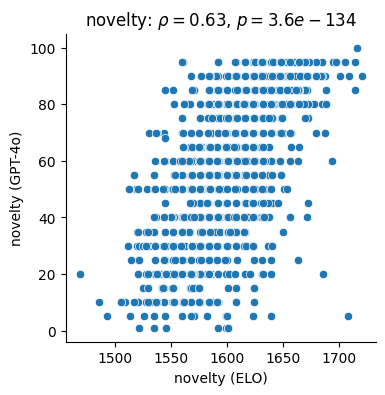

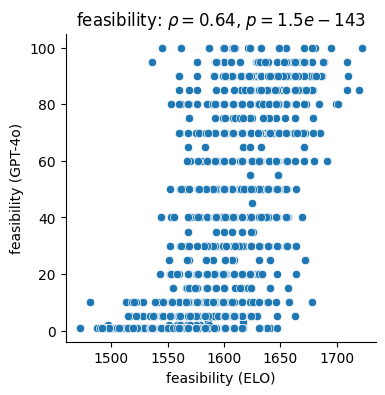

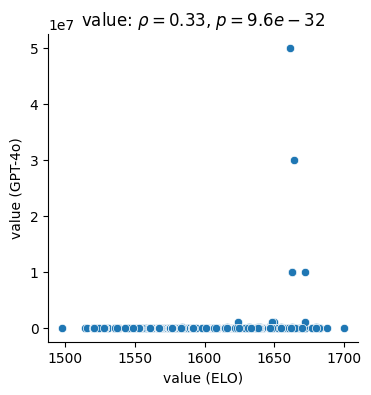

In [36]:
for key, c in corr.items():
    plt.figure(figsize=(4,4))
    sns.scatterplot(source, x=key.capitalize(), y=key)
    sns.despine()
    plt.xlabel(f'{key} (ELO)')
    plt.ylabel(f'{key} (GPT-4o)')
    plt.title(f'{key}: $\\rho = {c.statistic:.2g}$, $p = {c.pvalue:.2g}$')

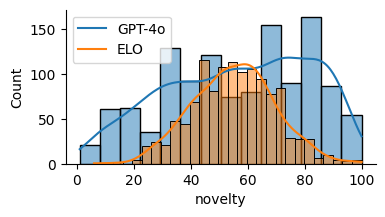

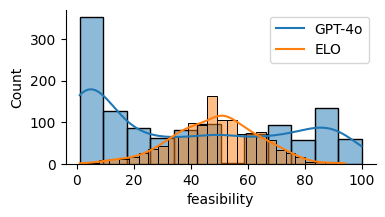

In [37]:
for key in ('novelty', 'feasibility'):
    fig, ax = plt.subplots(figsize=(4,2))
    sns.histplot(source, x=key, ax=ax, kde=True)
    sns.histplot(source, x=f'{key}_transformed', ax=ax, kde=True)
    sns.despine()
    plt.plot([], label='GPT-4o')
    plt.plot([], label='ELO')
    plt.legend()

In [38]:
negative = source[source['value']<0]
for idx, row in negative.iterrows():
    print(row['Question'], row['Answer'], row['value_explanation'], sep='\n', end='\n\n')
len(negative)

0

In [39]:
high = source[source['value'] > 100000]
for idx, row in high.iterrows():
    print(row['Question'], row['Answer'], row['value'], row['value_idea_explanation'], row['value_explanation'], sep='\n', end='\n\n')
len(high)

傘
パラシュート
300000
3. Use as a parachute.
Parachutes are highly specialized and can cost from 100,000 to 500,000 JPY.

ストロー
家の建築
1000000
3. House Construction
Using straws to build a house.
Building materials for houses are extremely expensive, often in the millions of JPY.

ボールペン
家
10000000
8. Use a ballpoint pen to build a house.
Existing products: Construction materials and tools for building houses.

トイレットペーパー
家の建築
10000000
15. House construction
Building materials for houses are extremely expensive, often costing millions of JPY.

コルク
家の建築
30000000
20. House construction
The cost of building a house can range from 10,000,000 to 50,000,000 JPY.

レンガ
家
10000000
8. House
Using bricks to build a house.
Existing products: Construction materials for houses, valued in the millions of JPY.

テープ
乗り物
1000000
19. Use tape as a vehicle.
Existing products: Vehicles and transportation means, which are very expensive.

ボールペン
橋
1000000
19. Use as a bridge
Bridges are large-scale structures costing m

11

Text(0.5, 1.0, 'value: $\\rho = 0.32$, $p = 1.2e-28$')

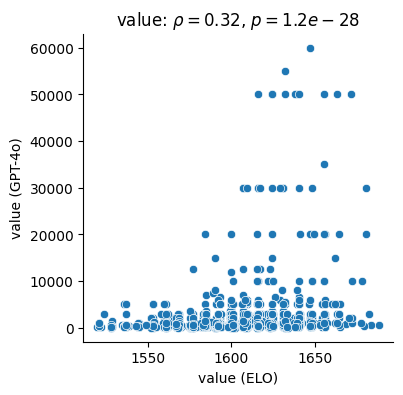

In [40]:
mask = (source['value']>0) & (source['value']<100000)
vcorr = stats.spearmanr(source[mask][['Value', 'value']])
plt.figure(figsize=(4,4))
sns.scatterplot(source[mask], x='Value', y='value')
sns.despine()
plt.xlabel(f'value (ELO)')
plt.ylabel(f'value (GPT-4o)')
plt.title(f'value: $\\rho = {vcorr.statistic:.2g}$, $p = {vcorr.pvalue:.2g}$')

In [41]:
print(source[(source['Question']=='ボールペン')*(source['Answer']=='冷蔵庫')]['novelty_raw'].item())

3. Using the pen as a refrigerator.
This idea is extremely novel and surprising, as it is highly unconventional and imaginative.
{"novelty": 95}


In [42]:
print(source[(source['Question']=='ボールペン')*(source['Answer']=='冷蔵庫')]['feasibility_raw'].item())

3. Refrigerator
Feasibility: A ballpoint pen cannot function as a refrigerator due to its size and lack of cooling mechanisms.
{"feasibility": 1}


In [43]:
print(source[(source['Question']=='ボールペン')*(source['Answer']=='冷蔵庫')]['value_raw'].item())

3. Refrigerator.
Small refrigerators or mini-fridges are priced around 10,000-20,000 JPY.
{"value":15000}
